In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
from scipy import signal
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

## Чтение и визуализация временного ряда

In [6]:
test_file='C:/Users/Julia/Documents/ITMO/ITMO_master_degree_classes/Research_work(NEMO)/(2014)19.875_75.875.csv'
df=pd.read_csv(test_file, sep=';')
df['dates'] =  pd.to_datetime(df['dates'], format='%Y-%m-%d')
df

,dates,sea_level
0,2014-01-01,-0.2052
1,2014-01-02,-0.2025
2,2014-01-03,-0.2009
3,2014-01-04,-0.1966
4,2014-01-05,-0.2005
...,...,...
360,2014-12-27,-0.2679
361,2014-12-28,-0.2632
362,2014-12-29,-0.2609
363,2014-12-30,-0.2635


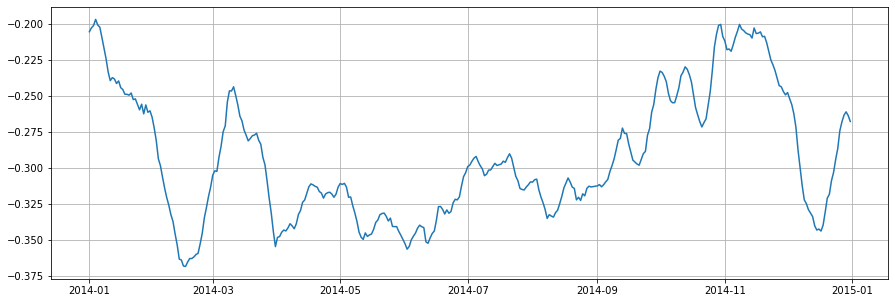

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(df['dates'], df['sea_level'])
plt.grid()
plt.show()

## Частотная оценка ряда

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


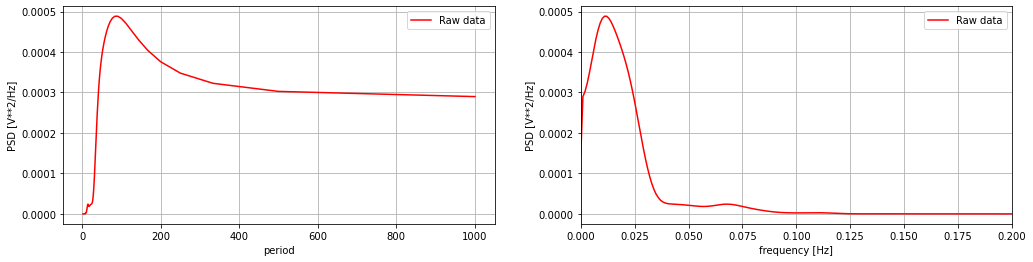

In [8]:
plt.rcParams['figure.figsize'] = [17, 4]

b_f, b_Pxx_den = signal.welch(df['sea_level'], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)

plt.subplot(1, 2, 1)
plt.plot(1/b_f, b_Pxx_den, c='r', label='Raw data')
plt.grid()

plt.legend()
plt.xlabel('period')
plt.ylabel('PSD [V**2/Hz]')

plt.subplot(1, 2, 2)
plt.plot(b_f, b_Pxx_den, c='r', label='Raw data')
plt.xlim(0, 0.2)
plt.grid()
plt.legend()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## похоже что 14 (луна) и 90 дней (пассаты)

## Оценка цикличности и остатков

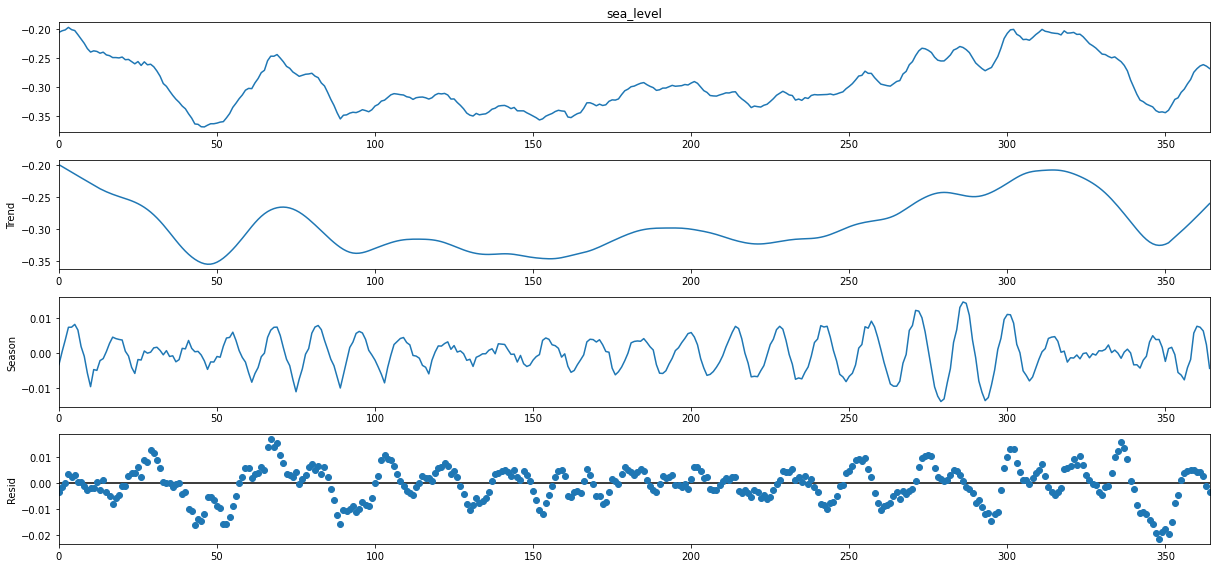

In [76]:
plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df['sea_level'], period=14)
res = stl.fit()
fig = res.plot()

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


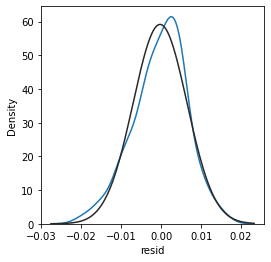

KstestResult(statistic=0.05249211551610222, pvalue=0.2578281527356442)


In [77]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)

## ***Спорно: так как ошибки нормально распределены, вычитаем их из основного ряда, моделируем только цикличность и тренд***

## Моделируем сезонность

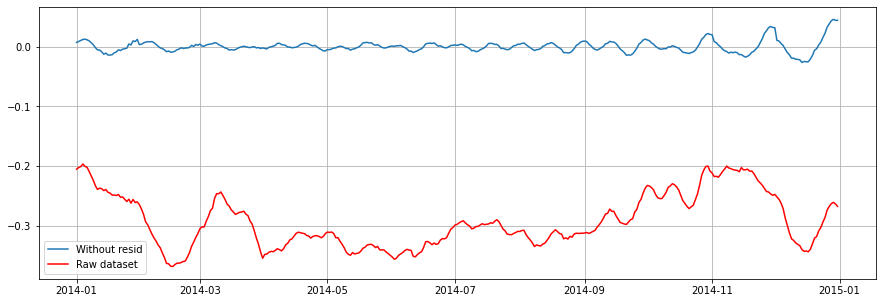

In [67]:
plt.rcParams['figure.figsize'] = [15, 5]
ds_no_resid=df['sea_level']-res.resid-res.trend
df['sea_level_no_resid_trend']=ds_no_resid
plt.plot(df['dates'], df['sea_level_no_resid_trend'], label='Without resid')
plt.plot(df['dates'], df['sea_level'], c='r', label='Raw dataset')
plt.legend()
plt.grid()
plt.show()

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


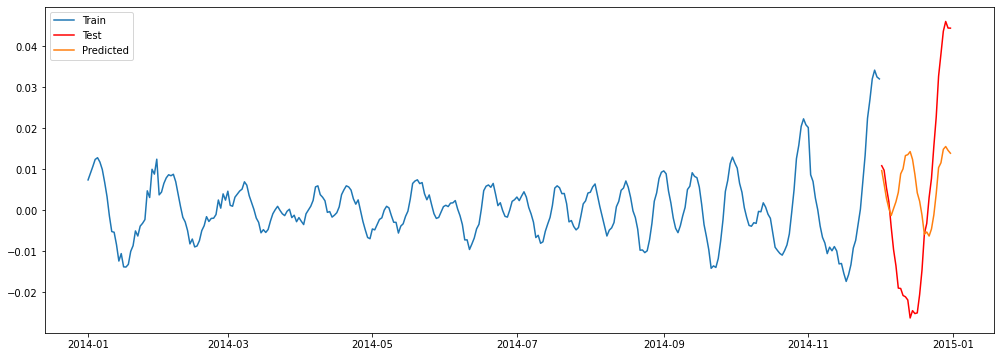

In [68]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['figure.figsize'] = [17, 6]

test = df['sea_level_no_resid_trend'][-30:]
test.index = df['dates'][-30:]
data = df['sea_level_no_resid_trend'][:-30]
data.index = df['dates'][:-30]

stlf = STLForecast(data, ARIMA, period=90, model_kwargs={"order": (2, 1, 0)})
model_res = stlf.fit()
forecasts = model_res.forecast(30)
plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(data, label='Train')
plt.plot(test, c='r', label='Test')
plt.plot(forecasts, label='Predicted')
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("MSE = ", mean_squared_error(test, forecasts))
print("MAE = ", mean_absolute_error(test, forecasts))
print("MAPE = ", round(np.mean(np.abs(test-forecasts)/test)*100,3))
print("R^2 = ", r2_score(test, forecasts))

MSE =  0.0005493406737094008
MAE =  0.019805675874818594
MAPE =  -20.327
R^2 =  0.03617357913934016


## Моделируем тренд

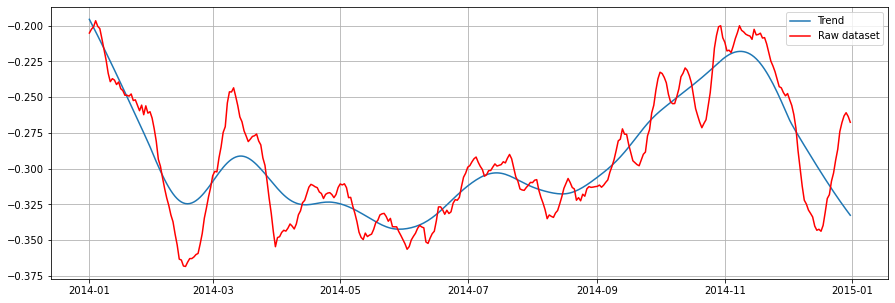

In [69]:
plt.rcParams['figure.figsize'] = [15, 5]
df['sea_level_trend']=res.trend
plt.plot(df['dates'], df['sea_level_trend'], label='Trend')
plt.plot(df['dates'], df['sea_level'], c='r', label='Raw dataset')
plt.legend()
plt.grid()
plt.show()

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


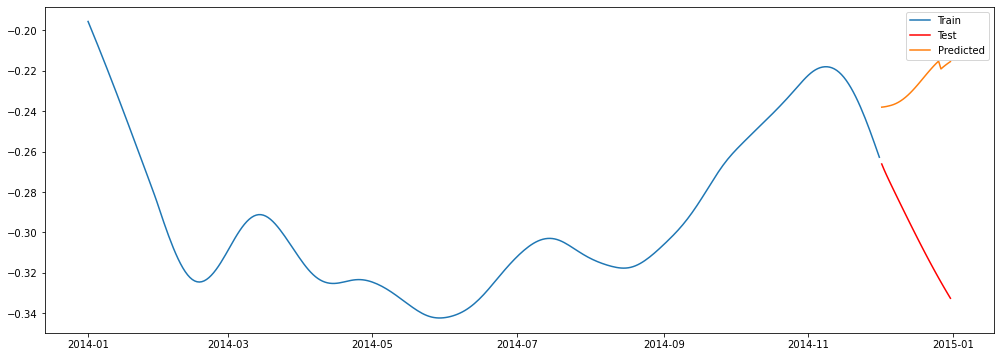

In [70]:
plt.rcParams['figure.figsize'] = [17, 6]

test = df['sea_level_trend'][-30:]
test.index = df['dates'][-30:]
data = df['sea_level_trend'][:-30]
data.index = df['dates'][:-30]

stlf = STLForecast(data, ARIMA, period=90, model_kwargs={"order": (2, 1, 0)})
model_res = stlf.fit()
forecasts = model_res.forecast(30)
plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(data, label='Train')
plt.plot(test, c='r', label='Test')
plt.plot(forecasts, label='Predicted')
plt.legend()
plt.show()

## Моделируем сезонность

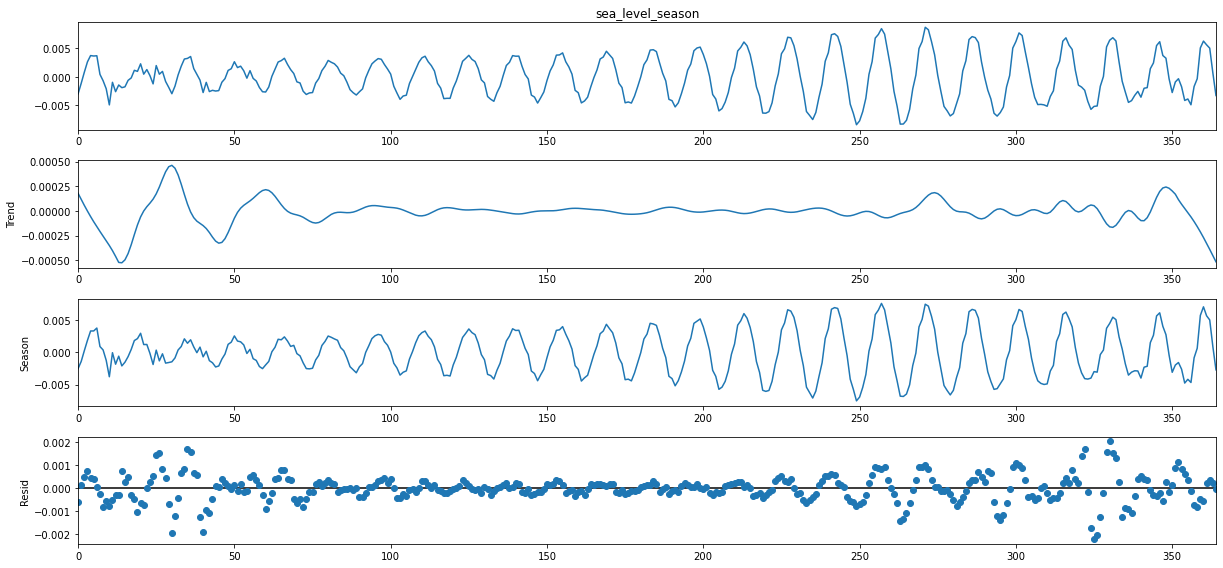

In [83]:
df['sea_level_season']=res.seasonal

plt.rcParams['figure.figsize'] = [17, 8]
stl = STL(df['sea_level_season'], period=14)
res = stl.fit()
fig = res.plot()

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


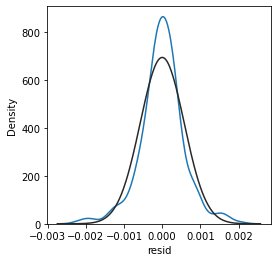

KstestResult(statistic=0.07625490748895375, pvalue=0.02717420402502002)


In [84]:
plt.rcParams['figure.figsize'] = [4, 4]
sns.distplot(res.resid, fit=norm, hist=False)
plt.show()
params = norm.fit(res.resid)
ks = kstest(res.resid, 'norm', params, N=1000)
print(ks)

### ***Значит остатки для сезонности тоже берем***

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


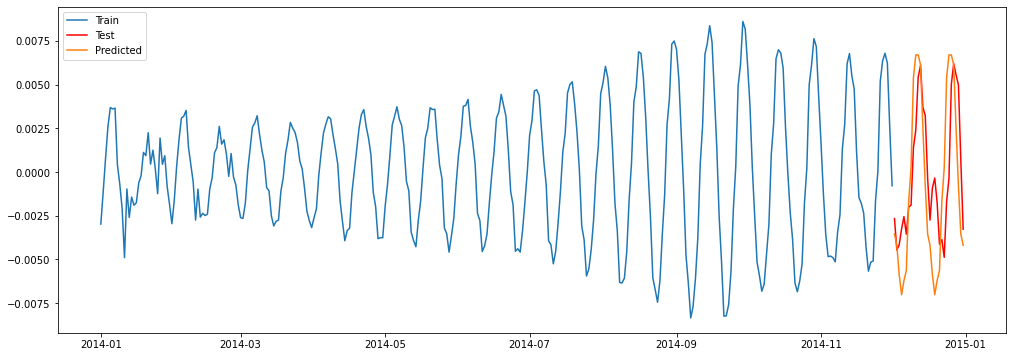

In [85]:

plt.rcParams['figure.figsize'] = [17, 6]

test = df['sea_level_season'][-30:]
test.index = df['dates'][-30:]
data = df['sea_level_season'][:-30]
data.index = df['dates'][:-30]

stlf = STLForecast(data, ARIMA, period=14, model_kwargs={"order": (2, 1, 0)})
model_res = stlf.fit()
forecasts = model_res.forecast(30)
plt.rcParams['figure.figsize'] = [17, 6]
plt.plot(data, label='Train')
plt.plot(test, c='r', label='Test')
plt.plot(forecasts, label='Predicted')
plt.legend()
plt.show()

In [86]:
print("MSE = ", mean_squared_error(test, forecasts))
print("MAE = ", mean_absolute_error(test, forecasts))
print("MAPE = ", round(np.mean(np.abs(test-forecasts)/test)*100,3))
print("R^2 = ", r2_score(test, forecasts))

MSE =  1.3113402495113293e-05
MAE =  0.002972180881674254
MAPE =  -180.408
R^2 =  -0.03380473200576284
